# Late Fusion Model with Feature Selection

This notebook implements **weighted late fusion** with **feature selection** to improve accuracy.

Modalities:
- **Physiological data** (pupil metrics) - normalized with StandardScaler
- **Behavioral data** (reaction time, decision time, etc.) - normalized with StandardScaler
- **Gaze data** (gaze position, movements, fixations) - normalized with StandardScaler

**Feature Selection Methods:**
1. **SelectKBest** (univariate) - Select top k features based on ANOVA F-value
2. **Recursive Feature Elimination (RFE)** - Recursively remove least important features
3. **L1 Regularization** (Lasso) - Use L1 penalty to zero out unimportant features

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

Goals:
1. Compare different feature selection methods
2. Identify optimal number of features per modality
3. Determine if feature selection improves fusion accuracy

In [1]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../../..')  # Add project root to path

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.utils.io import load_features, save_results
from src.utils.config import load_config
from src.utils.validation import validate_features
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*70}")
print(f"LATE FUSION WITH FEATURE SELECTION: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


LATE FUSION WITH FEATURE SELECTION: PRE-DECISION PERIOD



## 1. Load Pre-Extracted Features

In [2]:
# Load configuration
config = load_config('model_params')
time_window = config['time_windows'][f'{TIMEFRAME.lower()}_decision']

print(f"Time window: {time_window['start']}s to {time_window['end']}s")
print(f"Description: {time_window['description']}\n")

# Load pre-extracted features
features_path = f'../../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

# Validate loaded features
validate_features(merged_df, timeframe=TIMEFRAME)

print(f"\nFeature counts (before selection):")
print(f"  Physiology: {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")
print(f"  Total: {len(physio_cols) + len(behavior_cols) + len(gaze_cols)} features")

Time window: -2.0s to 0.0s
Description: Anticipatory period before submit button

✓ Validation passed (PRE): 12511 trials, 97 subjects
  Trials per subject: min=9, max=246, mean=129.0
  Outcome balance: 4273 keep / 8238 invest

Feature counts (before selection):
  Physiology: 13 features
  Behavior: 7 features
  Gaze: 20 features
  Total: 40 features


## 2. Prepare and Normalize Feature Sets

In [3]:
# Prepare feature arrays - ALL modalities normalized

# Physiology
X_physio_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
scaler_physio = StandardScaler()
X_physio = scaler_physio.fit_transform(X_physio_imputed)

# Behavior
X_behavior_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
scaler_behavior = StandardScaler()
X_behavior = scaler_behavior.fit_transform(X_behavior_imputed)

# Gaze
if len(gaze_cols) > 0:
    X_gaze_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
    scaler_gaze = StandardScaler()
    X_gaze = scaler_gaze.fit_transform(X_gaze_imputed)
else:
    X_gaze = np.zeros((len(merged_df), 1))

y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes after normalization:")
print(f"  X_physio:   {X_physio.shape}")
print(f"  X_behavior: {X_behavior.shape}")
print(f"  X_gaze:     {X_gaze.shape}")

Shapes after normalization:
  X_physio:   (12511, 13)
  X_behavior: (12511, 7)
  X_gaze:     (12511, 20)


## 3. Feature Selection Methods

In [4]:
def select_features_kbest(X, y, k='all'):
    """Select top k features using ANOVA F-value."""
    if k == 'all' or k >= X.shape[1]:
        return X, np.arange(X.shape[1])
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_idx = selector.get_support(indices=True)
    return X_selected, selected_idx

def select_features_rfe(X, y, n_features):
    """Select features using Recursive Feature Elimination."""
    if n_features >= X.shape[1]:
        return X, np.arange(X.shape[1])
    estimator = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features, step=1)
    X_selected = selector.fit_transform(X, y)
    selected_idx = selector.get_support(indices=True)
    return X_selected, selected_idx

def select_features_l1(X, y, C=1.0):
    """Select features using L1 regularization (Lasso)."""
    estimator = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, 
                                   class_weight='balanced', random_state=42, C=C)
    selector = SelectFromModel(estimator, prefit=False)
    X_selected = selector.fit_transform(X, y)
    selected_idx = selector.get_support(indices=True)
    if len(selected_idx) == 0:  # If all features removed, return original
        return X, np.arange(X.shape[1])
    return X_selected, selected_idx

print("Feature selection methods defined:")
print("  1. SelectKBest (ANOVA F-value)")
print("  2. RFE (Recursive Feature Elimination)")
print("  3. L1 Regularization (Lasso)")

Feature selection methods defined:
  1. SelectKBest (ANOVA F-value)
  2. RFE (Recursive Feature Elimination)
  3. L1 Regularization (Lasso)


## 4. Evaluate Feature Importance per Modality

In [5]:
def get_feature_importance(X, y, feature_names):
    """Get feature importance using ANOVA F-scores and L1 coefficients."""
    # ANOVA F-scores
    selector = SelectKBest(f_classif, k='all')
    selector.fit(X, y)
    f_scores = selector.scores_
    
    # L1 coefficients
    model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000,
                               class_weight='balanced', random_state=42, C=0.5)
    model.fit(X, y)
    l1_coefs = np.abs(model.coef_[0])
    
    return pd.DataFrame({
        'Feature': feature_names,
        'F_Score': f_scores,
        'L1_Coef': l1_coefs
    }).sort_values('F_Score', ascending=False)

# Analyze each modality
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print("\n--- Physiology Features ---")
physio_importance = get_feature_importance(X_physio, y, physio_cols)
print(physio_importance.to_string(index=False))

print("\n--- Behavior Features ---")
behavior_importance = get_feature_importance(X_behavior, y, behavior_cols)
print(behavior_importance.to_string(index=False))

if len(gaze_cols) > 0:
    print("\n--- Gaze Features ---")
    gaze_importance = get_feature_importance(X_gaze, y, gaze_cols)
    print(gaze_importance.head(10).to_string(index=False))
    print(f"  ... ({len(gaze_cols)} total features)")


FEATURE IMPORTANCE ANALYSIS

--- Physiology Features ---
                        Feature    F_Score  L1_Coef
                pupil_slope_pre 311.745748 0.335526
                  pupil_std_pre 194.731830 0.133952
          pct_time_dilating_pre 137.597624 0.074725
               time_to_peak_pre 110.505748 0.001328
         num_dilation_peaks_pre  85.380455 0.000374
        pupil_velocity_mean_pre  78.111829 0.024782
pupil_max_constriction_rate_pre  54.353378 0.064253
                 pupil_mean_pre  32.166001 0.001886
     pupil_acceleration_std_pre  17.685481 0.117753
    pupil_max_dilation_rate_pre   3.902877 0.077689
              eye_asymmetry_pre   0.217458 0.054271
          eye_asymmetry_std_pre   0.130430 0.054693
                   pupil_cv_pre   0.105930 0.005744

--- Behavior Features ---
         Feature     F_Score  L1_Coef
       ambiguity 1174.041666 0.644861
   reaction_time  437.593871 0.337667
   decision_time  345.938301 0.040520
    risk_premium  136.151530 0.1958

## 5. Helper Functions for Evaluation

In [6]:
def train_evaluate_modality(X, y, subjects, modality_name, verbose=True):
    """Train and evaluate a single modality using LOSO CV."""
    logo = LeaveOneGroupOut()
    subject_accs = []
    subject_f1s = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        subject_accs.append(accuracy_score(y_test, y_pred))
        subject_f1s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    
    acc = np.mean(subject_accs)
    f1 = np.mean(subject_f1s)
    
    if verbose:
        print(f"{modality_name}: Acc={acc:.3f}±{stats.sem(subject_accs):.3f}, F1={f1:.3f}")
    
    return acc, f1, subject_accs, subject_f1s

def weighted_late_fusion_logreg(X_modalities, y, subjects, verbose=True):
    """Weighted late fusion using Logistic Regression base models."""
    logo = LeaveOneGroupOut()
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        # Get out-of-fold predictions
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        n_inner = min(5, len(np.unique(train_subjects)) - 1)
        if n_inner < 2:
            n_inner = 2
        
        gkf_inner = GroupKFold(n_splits=n_inner)
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        # Test predictions
        test_probs = []
        for X in X_modalities:
            model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
            model.fit(X[train_idx], y_train)
            test_probs.append(model.predict_proba(X[test_idx])[:, 1])
        test_probs = np.column_stack(test_probs)
        
        # Meta-learner
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        y_pred = meta.predict(test_probs)
        
        test_subject = subjects[test_idx][0]
        subject_accs[test_subject] = accuracy_score(y_test, y_pred)
        subject_f1s[test_subject] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        all_weights.append(meta.coef_[0])
    
    acc_values = np.array(list(subject_accs.values()))
    f1_values = np.array(list(subject_f1s.values()))
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    if verbose:
        print(f"Fusion: Acc={np.mean(acc_values):.3f}±{stats.sem(acc_values):.3f}, F1={np.mean(f1_values):.3f}")
    
    return {
        'accuracy_mean': np.mean(acc_values),
        'accuracy_sem': stats.sem(acc_values),
        'f1_mean': np.mean(f1_values),
        'f1_sem': stats.sem(f1_values),
        'weights': norm_weights,
        'subject_accs': subject_accs
    }

## 6. Baseline: No Feature Selection

In [7]:
print("\n" + "="*60)
print("BASELINE: NO FEATURE SELECTION")
print("="*60)

# Individual modalities
acc_physio_base, f1_physio_base, _, _ = train_evaluate_modality(X_physio, y, subjects, "Physiology")
acc_behavior_base, f1_behavior_base, _, _ = train_evaluate_modality(X_behavior, y, subjects, "Behavior")

if len(gaze_cols) > 0:
    acc_gaze_base, f1_gaze_base, _, _ = train_evaluate_modality(X_gaze, y, subjects, "Gaze")
    X_modalities_base = [X_physio, X_behavior, X_gaze]
else:
    acc_gaze_base, f1_gaze_base = 0.5, 0.5
    X_modalities_base = [X_physio, X_behavior]

# Fusion
print("\nFusion (all features):")
results_baseline = weighted_late_fusion_logreg(X_modalities_base, y, subjects)

baseline_acc = results_baseline['accuracy_mean']
baseline_f1 = results_baseline['f1_mean']
print(f"\nBaseline fusion accuracy: {baseline_acc:.3f}")


BASELINE: NO FEATURE SELECTION
Physiology: Acc=0.536±0.014, F1=0.525
Behavior: Acc=0.647±0.013, F1=0.668
Gaze: Acc=0.500±0.016, F1=0.472

Fusion (all features):
Fusion: Acc=0.683±0.015, F1=0.660

Baseline fusion accuracy: 0.683


## 7. Feature Selection: SelectKBest

In [8]:
print("\n" + "="*60)
print("METHOD 1: SelectKBest (ANOVA F-value)")
print("="*60)

# Test different k values
k_values_physio = [3, 5, 7, 10, 13]  # max 13
k_values_behavior = [3, 5, 7]  # max 7
k_values_gaze = [5, 10, 15, 20] if len(gaze_cols) > 0 else []  # max 20

# Find best k for each modality
print("\n--- Physiology: Testing k values ---")
best_k_physio, best_acc_physio = None, 0
for k in k_values_physio:
    X_sel, _ = select_features_kbest(X_physio, y, k=k)
    acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  k={k}", verbose=True)
    if acc > best_acc_physio:
        best_k_physio, best_acc_physio = k, acc
print(f"  Best k={best_k_physio} (Acc={best_acc_physio:.3f})")

print("\n--- Behavior: Testing k values ---")
best_k_behavior, best_acc_behavior = None, 0
for k in k_values_behavior:
    X_sel, _ = select_features_kbest(X_behavior, y, k=k)
    acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  k={k}", verbose=True)
    if acc > best_acc_behavior:
        best_k_behavior, best_acc_behavior = k, acc
print(f"  Best k={best_k_behavior} (Acc={best_acc_behavior:.3f})")

if len(gaze_cols) > 0:
    print("\n--- Gaze: Testing k values ---")
    best_k_gaze, best_acc_gaze = None, 0
    for k in k_values_gaze:
        X_sel, _ = select_features_kbest(X_gaze, y, k=k)
        acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  k={k}", verbose=True)
        if acc > best_acc_gaze:
            best_k_gaze, best_acc_gaze = k, acc
    print(f"  Best k={best_k_gaze} (Acc={best_acc_gaze:.3f})")


METHOD 1: SelectKBest (ANOVA F-value)

--- Physiology: Testing k values ---
  k=3: Acc=0.543±0.015, F1=0.530
  k=5: Acc=0.540±0.015, F1=0.525
  k=7: Acc=0.541±0.014, F1=0.530
  k=10: Acc=0.539±0.014, F1=0.528
  k=13: Acc=0.536±0.014, F1=0.525
  Best k=3 (Acc=0.543)

--- Behavior: Testing k values ---
  k=3: Acc=0.644±0.013, F1=0.666
  k=5: Acc=0.647±0.013, F1=0.668
  k=7: Acc=0.647±0.013, F1=0.668
  Best k=5 (Acc=0.647)

--- Gaze: Testing k values ---
  k=5: Acc=0.500±0.017, F1=0.471
  k=10: Acc=0.493±0.017, F1=0.453
  k=15: Acc=0.493±0.018, F1=0.452
  k=20: Acc=0.500±0.016, F1=0.472
  Best k=5 (Acc=0.500)


In [9]:
# Apply best k values and run fusion
print("\n--- Fusion with SelectKBest ---")

X_physio_kbest, idx_physio = select_features_kbest(X_physio, y, k=best_k_physio)
X_behavior_kbest, idx_behavior = select_features_kbest(X_behavior, y, k=best_k_behavior)

print(f"Selected features:")
print(f"  Physiology ({best_k_physio}): {[physio_cols[i] for i in idx_physio]}")
print(f"  Behavior ({best_k_behavior}): {[behavior_cols[i] for i in idx_behavior]}")

if len(gaze_cols) > 0:
    X_gaze_kbest, idx_gaze = select_features_kbest(X_gaze, y, k=best_k_gaze)
    print(f"  Gaze ({best_k_gaze}): {[gaze_cols[i] for i in idx_gaze]}")
    X_modalities_kbest = [X_physio_kbest, X_behavior_kbest, X_gaze_kbest]
else:
    X_modalities_kbest = [X_physio_kbest, X_behavior_kbest]

results_kbest = weighted_late_fusion_logreg(X_modalities_kbest, y, subjects)
print(f"\nImprovement over baseline: {results_kbest['accuracy_mean'] - baseline_acc:+.3f}")


--- Fusion with SelectKBest ---
Selected features:
  Physiology (3): ['pupil_std_pre', 'pupil_slope_pre', 'pct_time_dilating_pre']
  Behavior (5): ['reaction_time', 'decision_time', 'invest_variance', 'ambiguity', 'risk_premium']
  Gaze (5): ['gaze_x_std', 'screen_y_mean', 'gaze_velocity_max', 'gaze_dispersion_x', 'gaze_dispersion_y']
Fusion: Acc=0.684±0.015, F1=0.661

Improvement over baseline: +0.002


## 8. Feature Selection: RFE

In [10]:
print("\n" + "="*60)
print("METHOD 2: Recursive Feature Elimination (RFE)")
print("="*60)

# Use same k values as SelectKBest for comparison
print("\n--- Physiology: Testing n_features ---")
best_n_physio_rfe, best_acc_physio_rfe = None, 0
for n in k_values_physio:
    X_sel, _ = select_features_rfe(X_physio, y, n_features=n)
    acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  n={n}", verbose=True)
    if acc > best_acc_physio_rfe:
        best_n_physio_rfe, best_acc_physio_rfe = n, acc
print(f"  Best n={best_n_physio_rfe} (Acc={best_acc_physio_rfe:.3f})")

print("\n--- Behavior: Testing n_features ---")
best_n_behavior_rfe, best_acc_behavior_rfe = None, 0
for n in k_values_behavior:
    X_sel, _ = select_features_rfe(X_behavior, y, n_features=n)
    acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  n={n}", verbose=True)
    if acc > best_acc_behavior_rfe:
        best_n_behavior_rfe, best_acc_behavior_rfe = n, acc
print(f"  Best n={best_n_behavior_rfe} (Acc={best_acc_behavior_rfe:.3f})")

if len(gaze_cols) > 0:
    print("\n--- Gaze: Testing n_features ---")
    best_n_gaze_rfe, best_acc_gaze_rfe = None, 0
    for n in k_values_gaze:
        X_sel, _ = select_features_rfe(X_gaze, y, n_features=n)
        acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  n={n}", verbose=True)
        if acc > best_acc_gaze_rfe:
            best_n_gaze_rfe, best_acc_gaze_rfe = n, acc
    print(f"  Best n={best_n_gaze_rfe} (Acc={best_acc_gaze_rfe:.3f})")


METHOD 2: Recursive Feature Elimination (RFE)

--- Physiology: Testing n_features ---
  n=3: Acc=0.538±0.015, F1=0.521
  n=5: Acc=0.541±0.014, F1=0.529
  n=7: Acc=0.540±0.014, F1=0.528
  n=10: Acc=0.536±0.014, F1=0.526
  n=13: Acc=0.536±0.014, F1=0.525
  Best n=5 (Acc=0.541)

--- Behavior: Testing n_features ---
  n=3: Acc=0.646±0.013, F1=0.667
  n=5: Acc=0.648±0.013, F1=0.669
  n=7: Acc=0.647±0.013, F1=0.668
  Best n=5 (Acc=0.648)

--- Gaze: Testing n_features ---
  n=5: Acc=0.529±0.013, F1=0.524
  n=10: Acc=0.528±0.014, F1=0.530
  n=15: Acc=0.532±0.016, F1=0.510
  n=20: Acc=0.500±0.016, F1=0.472
  Best n=15 (Acc=0.532)


In [11]:
# Apply best n values and run fusion
print("\n--- Fusion with RFE ---")

X_physio_rfe, idx_physio_rfe = select_features_rfe(X_physio, y, n_features=best_n_physio_rfe)
X_behavior_rfe, idx_behavior_rfe = select_features_rfe(X_behavior, y, n_features=best_n_behavior_rfe)

print(f"Selected features:")
print(f"  Physiology ({best_n_physio_rfe}): {[physio_cols[i] for i in idx_physio_rfe]}")
print(f"  Behavior ({best_n_behavior_rfe}): {[behavior_cols[i] for i in idx_behavior_rfe]}")

if len(gaze_cols) > 0:
    X_gaze_rfe, idx_gaze_rfe = select_features_rfe(X_gaze, y, n_features=best_n_gaze_rfe)
    print(f"  Gaze ({best_n_gaze_rfe}): {[gaze_cols[i] for i in idx_gaze_rfe]}")
    X_modalities_rfe = [X_physio_rfe, X_behavior_rfe, X_gaze_rfe]
else:
    X_modalities_rfe = [X_physio_rfe, X_behavior_rfe]

results_rfe = weighted_late_fusion_logreg(X_modalities_rfe, y, subjects)
print(f"\nImprovement over baseline: {results_rfe['accuracy_mean'] - baseline_acc:+.3f}")


--- Fusion with RFE ---
Selected features:
  Physiology (5): ['pupil_std_pre', 'pupil_slope_pre', 'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre', 'pct_time_dilating_pre']
  Behavior (5): ['reaction_time', 'ev_difference', 'invest_variance', 'ambiguity', 'risk_premium']
  Gaze (15): ['gaze_x_std', 'screen_x_std', 'screen_y_mean', 'screen_y_std', 'gaze_velocity_mean', 'gaze_velocity_std', 'gaze_velocity_max', 'gaze_acceleration_mean', 'gaze_acceleration_std', 'fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']
Fusion: Acc=0.684±0.015, F1=0.662

Improvement over baseline: +0.002


## 9. Feature Selection: L1 Regularization

In [12]:
print("\n" + "="*60)
print("METHOD 3: L1 Regularization (Lasso)")
print("="*60)

# Test different C values (smaller C = more regularization = fewer features)
C_values = [0.01, 0.05, 0.1, 0.5, 1.0]

print("\n--- Physiology: Testing C values ---")
best_C_physio, best_acc_physio_l1 = None, 0
for C in C_values:
    X_sel, idx = select_features_l1(X_physio, y, C=C)
    acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  C={C} ({X_sel.shape[1]} feat)", verbose=True)
    if acc > best_acc_physio_l1:
        best_C_physio, best_acc_physio_l1 = C, acc
print(f"  Best C={best_C_physio} (Acc={best_acc_physio_l1:.3f})")

print("\n--- Behavior: Testing C values ---")
best_C_behavior, best_acc_behavior_l1 = None, 0
for C in C_values:
    X_sel, idx = select_features_l1(X_behavior, y, C=C)
    acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  C={C} ({X_sel.shape[1]} feat)", verbose=True)
    if acc > best_acc_behavior_l1:
        best_C_behavior, best_acc_behavior_l1 = C, acc
print(f"  Best C={best_C_behavior} (Acc={best_acc_behavior_l1:.3f})")

if len(gaze_cols) > 0:
    print("\n--- Gaze: Testing C values ---")
    best_C_gaze, best_acc_gaze_l1 = None, 0
    for C in C_values:
        X_sel, idx = select_features_l1(X_gaze, y, C=C)
        acc, _, _, _ = train_evaluate_modality(X_sel, y, subjects, f"  C={C} ({X_sel.shape[1]} feat)", verbose=True)
        if acc > best_acc_gaze_l1:
            best_C_gaze, best_acc_gaze_l1 = C, acc
    print(f"  Best C={best_C_gaze} (Acc={best_acc_gaze_l1:.3f})")


METHOD 3: L1 Regularization (Lasso)

--- Physiology: Testing C values ---
  C=0.01 (3 feat): Acc=0.546±0.015, F1=0.535
  C=0.05 (8 feat): Acc=0.538±0.014, F1=0.527
  C=0.1 (9 feat): Acc=0.539±0.014, F1=0.528
  C=0.5 (13 feat): Acc=0.536±0.014, F1=0.525
  C=1.0 (13 feat): Acc=0.536±0.014, F1=0.525
  Best C=0.01 (Acc=0.546)

--- Behavior: Testing C values ---
  C=0.01 (5 feat): Acc=0.647±0.013, F1=0.668
  C=0.05 (5 feat): Acc=0.647±0.013, F1=0.668
  C=0.1 (6 feat): Acc=0.647±0.013, F1=0.668
  C=0.5 (7 feat): Acc=0.647±0.013, F1=0.668
  C=1.0 (7 feat): Acc=0.647±0.013, F1=0.668
  Best C=0.01 (Acc=0.647)

--- Gaze: Testing C values ---
  C=0.01 (4 feat): Acc=0.502±0.017, F1=0.459
  C=0.05 (12 feat): Acc=0.494±0.016, F1=0.463
  C=0.1 (12 feat): Acc=0.493±0.016, F1=0.462
  C=0.5 (19 feat): Acc=0.500±0.016, F1=0.472
  C=1.0 (19 feat): Acc=0.500±0.016, F1=0.472
  Best C=0.01 (Acc=0.502)


In [13]:
# Apply best C values and run fusion
print("\n--- Fusion with L1 ---")

X_physio_l1, idx_physio_l1 = select_features_l1(X_physio, y, C=best_C_physio)
X_behavior_l1, idx_behavior_l1 = select_features_l1(X_behavior, y, C=best_C_behavior)

print(f"Selected features:")
print(f"  Physiology ({len(idx_physio_l1)}): {[physio_cols[i] for i in idx_physio_l1]}")
print(f"  Behavior ({len(idx_behavior_l1)}): {[behavior_cols[i] for i in idx_behavior_l1]}")

if len(gaze_cols) > 0:
    X_gaze_l1, idx_gaze_l1 = select_features_l1(X_gaze, y, C=best_C_gaze)
    print(f"  Gaze ({len(idx_gaze_l1)}): {[gaze_cols[i] for i in idx_gaze_l1]}")
    X_modalities_l1 = [X_physio_l1, X_behavior_l1, X_gaze_l1]
else:
    X_modalities_l1 = [X_physio_l1, X_behavior_l1]

results_l1 = weighted_late_fusion_logreg(X_modalities_l1, y, subjects)
print(f"\nImprovement over baseline: {results_l1['accuracy_mean'] - baseline_acc:+.3f}")


--- Fusion with L1 ---
Selected features:
  Physiology (3): ['pupil_slope_pre', 'pupil_acceleration_std_pre', 'pct_time_dilating_pre']
  Behavior (5): ['reaction_time', 'decision_time', 'invest_variance', 'ambiguity', 'risk_premium']
  Gaze (4): ['screen_x_mean', 'screen_y_mean', 'fixation_ratio', 'gaze_dispersion_x']
Fusion: Acc=0.683±0.015, F1=0.660

Improvement over baseline: +0.000


## 10. Summary: Compare All Methods

In [14]:
# Build comparison table
comparison_data = {
    'Method': [
        'Baseline (No Selection)',
        'SelectKBest',
        'RFE',
        'L1 Regularization'
    ],
    'Accuracy': [
        results_baseline['accuracy_mean'],
        results_kbest['accuracy_mean'],
        results_rfe['accuracy_mean'],
        results_l1['accuracy_mean']
    ],
    'Accuracy_SEM': [
        results_baseline['accuracy_sem'],
        results_kbest['accuracy_sem'],
        results_rfe['accuracy_sem'],
        results_l1['accuracy_sem']
    ],
    'F1-Score': [
        results_baseline['f1_mean'],
        results_kbest['f1_mean'],
        results_rfe['f1_mean'],
        results_l1['f1_mean']
    ],
    'Improvement': [
        0,
        results_kbest['accuracy_mean'] - baseline_acc,
        results_rfe['accuracy_mean'] - baseline_acc,
        results_l1['accuracy_mean'] - baseline_acc
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print(f"FEATURE SELECTION COMPARISON ({TIMEFRAME})")
print("="*70)
print(comparison_df.to_string(index=False))

# Find best method
best_idx = comparison_df['Accuracy'].idxmax()
best_method = comparison_df.loc[best_idx, 'Method']
best_acc = comparison_df.loc[best_idx, 'Accuracy']
best_improvement = comparison_df.loc[best_idx, 'Improvement']

print(f"\nBest Method: {best_method}")
print(f"  Accuracy: {best_acc:.3f}")
print(f"  Improvement over baseline: {best_improvement:+.3f}")


FEATURE SELECTION COMPARISON (PRE)
                 Method  Accuracy  Accuracy_SEM  F1-Score  Improvement
Baseline (No Selection)  0.682502      0.015235  0.660378     0.000000
            SelectKBest  0.684260      0.015349  0.661163     0.001758
                    RFE  0.684407      0.015279  0.662455     0.001905
      L1 Regularization  0.682749      0.015230  0.660487     0.000248

Best Method: RFE
  Accuracy: 0.684
  Improvement over baseline: +0.002


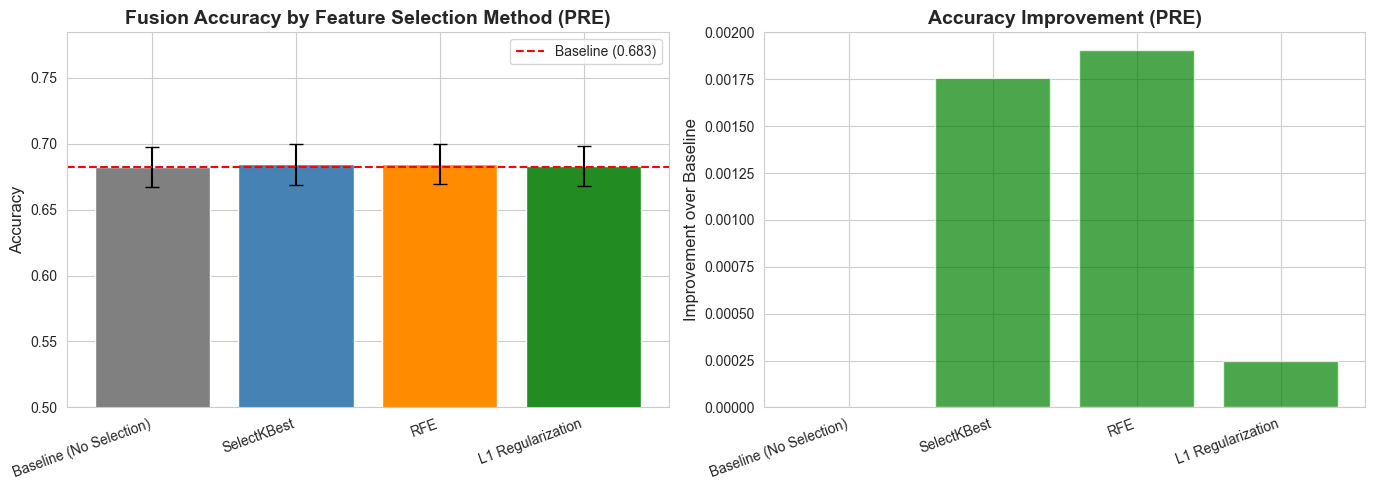

In [15]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1 = axes[0]
colors = ['gray', 'steelblue', 'darkorange', 'forestgreen']
bars = ax1.bar(comparison_df['Method'], comparison_df['Accuracy'], 
               yerr=comparison_df['Accuracy_SEM'], capsize=5, color=colors)
ax1.axhline(y=baseline_acc, color='red', linestyle='--', label=f'Baseline ({baseline_acc:.3f})')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title(f'Fusion Accuracy by Feature Selection Method ({TIMEFRAME})', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, max(comparison_df['Accuracy']) + 0.1)
ax1.legend()
ax1.set_xticklabels(comparison_df['Method'], rotation=20, ha='right')

# Improvement comparison
ax2 = axes[1]
improvements = comparison_df['Improvement'].values
bar_colors = ['green' if x > 0 else 'red' for x in improvements]
ax2.bar(comparison_df['Method'], improvements, color=bar_colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Improvement over Baseline', fontsize=12)
ax2.set_title(f'Accuracy Improvement ({TIMEFRAME})', fontsize=14, fontweight='bold')
ax2.set_xticklabels(comparison_df['Method'], rotation=20, ha='right')

plt.tight_layout()
plt.show()

## 11. Save Results

In [16]:
import os
output_dir = f'../../../data/results/fusion_feature_selection_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

# Save comparison results
save_results(comparison_df, f'{output_dir}/feature_selection_comparison_{TIMEFRAME}.csv')

# Save feature importance
save_results(physio_importance, f'{output_dir}/physio_feature_importance_{TIMEFRAME}.csv')
save_results(behavior_importance, f'{output_dir}/behavior_feature_importance_{TIMEFRAME}.csv')
if len(gaze_cols) > 0:
    save_results(gaze_importance, f'{output_dir}/gaze_feature_importance_{TIMEFRAME}.csv')

# Save selected features for best method
if best_method == 'SelectKBest':
    selected_features = {
        'Physiology': [physio_cols[i] for i in idx_physio],
        'Behavior': [behavior_cols[i] for i in idx_behavior]
    }
    if len(gaze_cols) > 0:
        selected_features['Gaze'] = [gaze_cols[i] for i in idx_gaze]
elif best_method == 'RFE':
    selected_features = {
        'Physiology': [physio_cols[i] for i in idx_physio_rfe],
        'Behavior': [behavior_cols[i] for i in idx_behavior_rfe]
    }
    if len(gaze_cols) > 0:
        selected_features['Gaze'] = [gaze_cols[i] for i in idx_gaze_rfe]
elif best_method == 'L1 Regularization':
    selected_features = {
        'Physiology': [physio_cols[i] for i in idx_physio_l1],
        'Behavior': [behavior_cols[i] for i in idx_behavior_l1]
    }
    if len(gaze_cols) > 0:
        selected_features['Gaze'] = [gaze_cols[i] for i in idx_gaze_l1]
else:
    selected_features = {'Physiology': physio_cols, 'Behavior': behavior_cols}
    if len(gaze_cols) > 0:
        selected_features['Gaze'] = gaze_cols

# Save as DataFrame
max_len = max(len(v) for v in selected_features.values())
selected_df = pd.DataFrame({k: v + [''] * (max_len - len(v)) for k, v in selected_features.items()})
save_results(selected_df, f'{output_dir}/best_selected_features_{TIMEFRAME}.csv')

print(f"\n✓ All results saved to: {output_dir}/")

✓ Saved results to: ../../../data/results/fusion_feature_selection_PRE/feature_selection_comparison_PRE.csv
✓ Saved results to: ../../../data/results/fusion_feature_selection_PRE/physio_feature_importance_PRE.csv
✓ Saved results to: ../../../data/results/fusion_feature_selection_PRE/behavior_feature_importance_PRE.csv
✓ Saved results to: ../../../data/results/fusion_feature_selection_PRE/gaze_feature_importance_PRE.csv
✓ Saved results to: ../../../data/results/fusion_feature_selection_PRE/best_selected_features_PRE.csv

✓ All results saved to: ../../../data/results/fusion_feature_selection_PRE/


## 12. Final Summary

In [17]:
print("\n" + "="*70)
print(f"FINAL SUMMARY ({TIMEFRAME})")
print("="*70)

print(f"\n1. BASELINE (All Features):")
print(f"   Total features: {X_physio.shape[1] + X_behavior.shape[1] + (X_gaze.shape[1] if len(gaze_cols) > 0 else 0)}")
print(f"   Fusion Accuracy: {baseline_acc:.3f}")

print(f"\n2. BEST METHOD: {best_method}")
print(f"   Fusion Accuracy: {best_acc:.3f}")
print(f"   Improvement: {best_improvement:+.3f}")

print(f"\n3. SELECTED FEATURES:")
for modality, features in selected_features.items():
    print(f"   {modality} ({len(features)}): {features}")

print(f"\n4. CONCLUSION:")
if best_improvement > 0.01:
    print(f"   Feature selection IMPROVED accuracy by {best_improvement:.3f}")
    print(f"   Recommended: Use {best_method} for feature selection")
elif best_improvement > -0.01:
    print(f"   Feature selection had MINIMAL impact ({best_improvement:+.3f})")
    print(f"   Recommendation: Either method is acceptable")
else:
    print(f"   Feature selection DECREASED accuracy by {abs(best_improvement):.3f}")
    print(f"   Recommendation: Keep all features (no selection)")

print("\n" + "="*70)


FINAL SUMMARY (PRE)

1. BASELINE (All Features):
   Total features: 40
   Fusion Accuracy: 0.683

2. BEST METHOD: RFE
   Fusion Accuracy: 0.684
   Improvement: +0.002

3. SELECTED FEATURES:
   Physiology (5): ['pupil_std_pre', 'pupil_slope_pre', 'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre', 'pct_time_dilating_pre']
   Behavior (5): ['reaction_time', 'ev_difference', 'invest_variance', 'ambiguity', 'risk_premium']
   Gaze (15): ['gaze_x_std', 'screen_x_std', 'screen_y_mean', 'screen_y_std', 'gaze_velocity_mean', 'gaze_velocity_std', 'gaze_velocity_max', 'gaze_acceleration_mean', 'gaze_acceleration_std', 'fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']

4. CONCLUSION:
   Feature selection had MINIMAL impact (+0.002)
   Recommendation: Either method is acceptable

